# Data-Driven Discovery of the Vlasov Equation
Techniques from data science and machine learning are offering new approaches to developing non-linear dynamical models of complex physical systems from directly from data [1-4]. Sparse Regression (SR) [1-3] is a one of these new and promising tools, which can infer interpetable differential equations of nonlinear dynamical systems from data. 

Recent work [4] has explored the potential of the SR approach to infer reduced plasma physics models (in the form of partial differential equations) from the data of first-principles particle-in-cell (PIC) simulations. In particular, it was shown that the SR methodology was capable of inferring the fundamental hierarchy of plasma physics models, from the kinetic Vlasov equation to single-fluid magnetohydrodynamics (MHD) from PIC simulation data. Importantly, in order to robustly handle the "noise" associated with discrete particle fluctuations, an integral formulation of the sparse identification of the underlying differential equations was used.

This notebook walks through the first example in [4] of inferring the kinetic Vlasov equation from PIC simulation data of the two-stream instability.

[1] S. L. Brunton, J. L. Proctor, and J. N. Kutz, Proceedings of the National Academy of Sciences 113, 3932 (2016)

[2] H. Schaeffer, Proceedings of the Royal Society A 473:20160446 (2017)

[3] S. H. Rudy, S. L. Brunton, J. L. Proctor, and J. N. Kutz, Science Advances 3, e1602614 (2017)

[4] E. P. Alves and F. Fiuza, Phys. Rev. Res. 4, 033192 (2022)

## Import modules

In [1]:
import numpy as np
import sys
import os
from ddplasma_utils import *
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

%matplotlib inline

## Load data
To demonstrate our equation discovery framework we choose a prototypical problem of non-linear plasma dynamics - the electrostatic two-stream instability. The two-stream instability is a fundamental instability in weakly collisional plasmas that is triggered in the presence of counter-streaming beams of charged particles. It is recognized to play an important role in radio bursts in the solar corona, driving turbulence in magnetized plasmas, and much more. 

The data for this notebook can be downloaded at:
https://doi.org/10.5281/zenodo.7968600

Download both 'fld_data.pkl' and 'phase_space_data.pkl' files and store them in a folder called 'data' in your local directory.

Once you've downloaded the data, the cell below will load the data and store it as two python dictionaries: fld_data and ps_data.

ps_data is a dictionary which stores the electron distribution function - spec_data['F'][t_i,u_i,x_i] - and information about the t,u,x phase space coordinates (t is the time coordinate, u is the proper velocity coordinate in the x direction, and x is the spatial coordinate). fld_data is a dictionary which stores the electric field - fld_data['E'][t_i,x_i].

In [15]:
def load_obj(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Loading field data
fld_data = load_obj('./data/fld_data.pkl')
# Loading data of plasma dynamics in phase space
ps_data = load_obj('./data/phase_space_data.pkl')

print(list(fld_data.keys()))
print(list(ps_data.keys()))

['x', 'dx', 'dt', 't', 'E']
['u', 't', 'v', 'x', 'du', 'dt', 'dx', 'F']


## Visualize F(u,x), E(x) at a time slice
To plot the instability at different times change the time step interation, i_t, between 0 and 458.

Text(0, 0.5, '$v [c], E [m_ec\\omega_{pe}/3e]$')

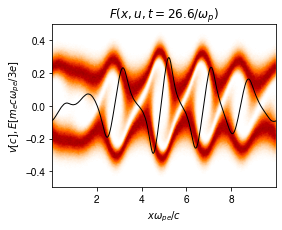

In [16]:
i_t = 300 # time step iteration 

# Plot data
x_arr = ps_data['x']
u_arr = ps_data['u']
t_arr = ps_data['t']

dx = x_arr[1] - x_arr[0]
du = u_arr[1] - u_arr[0]
dt = t_arr[1] - t_arr[0]

plt.figure(figsize=(4,3))
plt.title(r'$F(x,u,t = ' +str(round(t_arr[i_t],2))+ '/\omega_p)$')
plt.imshow(ps_data['F'][i_t, :, :], origin='lower', 
           extent=[x_arr[0], x_arr[-1], u_arr[0], u_arr[-1]], aspect='auto', cmap = 'gist_heat_r', vmax = 7)
plt.plot(fld_data['x'], 3*fld_data['E'][i_t,:], c = 'k', lw = 1.)
plt.xlabel(r'$x\omega_{pe}/c$')
plt.ylabel(r'$v [c], E [m_ec\omega_{pe}/3e]$')

## Sampling measurement locations
The first step is randomly sampling locations in phase space to take measurements. Rather than sample our data at discrete phase space points, we randomly sample small, compact phase space volumes and then integrate our measurements over these small volumes. This is to crucial to capture low frequency phenomena embedded in high frequency noise where numeral differentiation breaks down. The size of these volumes is problem dependant; the volumes must be smaller than characteristic length scales of physical variation, yet large enough to smooth noise associated with discrete particle affects. Additionally, to ensure that we are sampling regions of phase space where dynamics are occuring we only select volumes where F>0.25. 

In the following example, the compact volumes have a size of $5\times5\times5$ points in $(t,u,x)$, and $1000$ of these volumes are selected. 

In [17]:
def get_sampling_points(ps_data, num_tux0, vol_tux, lowerbound_t = 200, upperbound_t = 300):

    np.random.seed(188)

    nt, nu, nx = ps_data['F'].shape

    # Sample a collection of data points, stay away from edges so I can just use centered finite differences.
    num_x0 = num_tux0[0]
    num_u0 = num_tux0[1]
    num_t0 = num_tux0[2]
    w_x  = vol_tux[0]
    w_u  = vol_tux[1]
    w_t  = vol_tux[2]
    num_vols = num_t0 * num_u0 * num_x0
    num_points_per_vol = (w_t*w_u*w_x)


    lowerbound_x = 10
    upperbound_x = nx-30
    lowerbound_u = 48
    upperbound_u = nu-48


    points = np.zeros((num_vols, 3, num_points_per_vol), dtype=int)

    f_thresh = 0.25

    tux_throws = 0
    while tux_throws < num_t0*num_u0*num_x0:
        x0 = np.random.randint(lowerbound_x, upperbound_x)
        u0 = np.random.randint(lowerbound_u, upperbound_u)
        t0 = np.random.choice(np.arange(lowerbound_t, upperbound_t), 1, replace=True)[0]
        if ps_data['F'][t0, u0 ,x0] > f_thresh:
            t_range, u_range, x_range = np.meshgrid(np.arange(t0, t0+w_t), np.arange(u0, u0+w_u), np.arange(x0, x0+w_x), indexing='xy')
            points[tux_throws, 0, :] = t_range.flatten()
            points[tux_throws, 1, :] = u_range.flatten()
            points[tux_throws, 2, :] = x_range.flatten()
            tux_throws +=1
            
    return points


# this routine randomly selects 1000 cubic volumes of 5dx*5dv*5dt each
points = get_sampling_points(ps_data, num_tux0 = [10, 10, 10], vol_tux = [5, 5, 5], lowerbound_t = 270, upperbound_t = 370)



## Plot sampled volumes on top of data

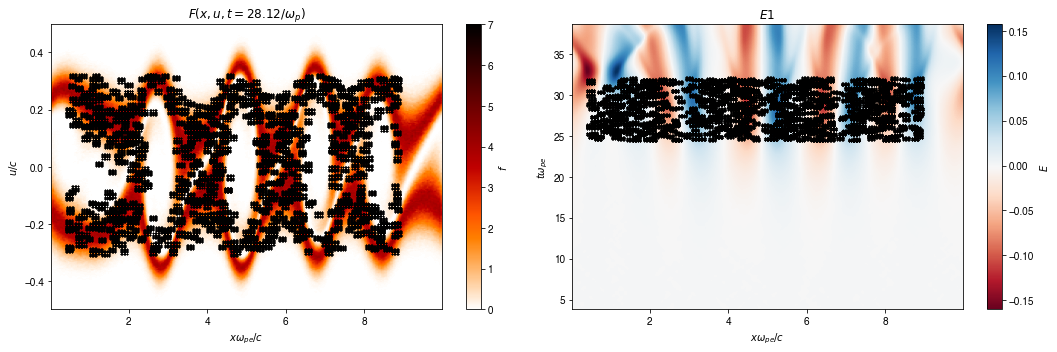

In [18]:
def plot_sample_points_on_data(ps_data, fld_data, points):
    ps = []
    for i in range(len(points)):
        t, u, x = points[i]
        for j in range(len(t)):
            ps.append([x[j], u[j], t[j]])
    ps = np.array(ps)

    i_t = 320
    
    x_arr = ps_data['x']
    u_arr = ps_data['u']
    t_arr = ps_data['t']
    
    dx = x_arr[1] - x_arr[0]
    du = u_arr[1] - u_arr[0]
    dt = t_arr[1] - t_arr[0]

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(r'$F(x,u,t ='+ str(round(t_arr[i_t],2))+'/\omega_p)$')
    plt.imshow(ps_data['F'][i_t, :, :], origin='lower', 
               extent=[x_arr[0], x_arr[-1], u_arr[0], u_arr[-1]], aspect='auto', cmap = 'gist_heat_r', vmax = 7)
    plt.xlabel(r'$x\omega_{pe}/c$')
    plt.ylabel(r'$u/c$')
    plt.colorbar(label = r'$f$')
    plt.scatter(ps[:,0]*dx, u_arr[0] + ps[:,1]*du, c = 'k', s=0.25)

    plt.subplot(1,2,2)
    plt.title(r'$E1$')
    plt.imshow(fld_data['E'][:, :], origin='lower', 
               extent=[x_arr[0], x_arr[-1], t_arr[0], t_arr[-1]], aspect='auto', cmap = 'RdBu')
    plt.xlabel(r'$x\omega_{pe}/c$')
    plt.ylabel(r'$t\omega_{pe}$')
    plt.colorbar(label = r'$E$')
    plt.scatter(x_arr[0] + ps[:,0]*dx, t_arr[0] + ps[:,2]*dt, c = 'k', s=0.25)
    plt.tight_layout()
    
    
plot_sample_points_on_data(ps_data, fld_data, points)

## Evaluate primary candidate PDE terms within sampled volumes

In [19]:
def collect_sample_data_and_derivatives(ps_data, fld_data, points, O = 2):
    # This routine evaluates the primary candidate PDE terms at sampled points on the data.
    # By primary candidate PDE terms I mean the main dynamical variables of the system and their gradients.
    # In this example, the main dynamical variables are the distribution function (F), the electric field (E) and the phase space coordinates (x,v).
    # This routine outputs the values of (F, E, x, v, and their gradients) at the sample points in a dictionary called "features".
    # The time derivative of F (F_t), which is the target variable for which we want to discover the governing PDE, is output in the dictionary "y_quants".
    # The "O" parameter controls the order of accuracy of the finite differencing stencils to estimate derivatives. 
    # By default we use "O = 2" corresponding to second order accurate finite differences.
    
    num_vols = len(points)
    num_points_per_vol = np.array(points[1]).shape[-1]
    
    dx = ps_data['dx']
    du = ps_data['du'] 
    dt = ps_data['dt']

    # initialize y_quants
    y_quants = {}
    for quant in ['F_t']:
        y_quants[quant] = np.zeros((num_vols, num_points_per_vol, 1))

    # initialize features dictionary
    features = {}
    ps_quants = ['F', 'v', 'u', 'x']
    fld_quants = ['E']
    for quant in ps_quants+fld_quants:
        features[quant] = np.zeros((num_vols, num_points_per_vol, 1))
        if quant not in ['v', 'u', 'x']:
            features[quant+'_x']  = np.zeros((num_vols, num_points_per_vol, 1))
            features[quant+'_u']  = np.zeros((num_vols, num_points_per_vol, 1))
            features[quant+'_xx'] = np.zeros((num_vols, num_points_per_vol, 1))
            features[quant+'_uu'] = np.zeros((num_vols, num_points_per_vol, 1))


    # Evaluating derivatives
    for p in range(len(points)):
        if p%int(len(points)/10) ==0:
            print('Progress: ', np.round(p/len(points)*100, -1), '%')

        [t_range, u_range, x_range]  = points[p]

        for i in range(num_points_per_vol):
            t, u, x = t_range[i], u_range[i], x_range[i]

            # Species data
            for quant in ['F']:
                features[quant][p, i] = ps_data[quant][t, u, x]
                features[quant+'_x'][p, i]  = FiniteDiffPoint(ps_data[quant][t, u, :], i_x = x, 
                                                              dx = dx, d = 1, O = O)
                features[quant+'_u'][p, i]  = FiniteDiffPoint(ps_data[quant][t, :, x], i_x = u, 
                                                              dx = du, d = 1, O = O)
                features[quant+'_xx'][p, i] = FiniteDiffPoint(ps_data[quant][t, u, :], i_x = x, 
                                                              dx = dx, d = 2, O = O)
                features[quant+'_uu'][p, i] = FiniteDiffPoint(ps_data[quant][t, :, x], i_x = u, 
                                                              dx = du, d = 2, O = O)

            features['v'][p, i] = ps_data['v'][u]
            features['u'][p, i] = ps_data['u'][u]
            features['x'][p, i] = ps_data['x'][x]

            # Fld data
            for quant in fld_quants:
                features[quant][p, i] = fld_data[quant][t, x]
                features[quant+'_x'][p, i]  = FiniteDiffPoint(fld_data[quant][t, :], i_x = x, 
                                                              dx = dx, d = 1, O = O)
                features[quant+'_xx'][p, i] = FiniteDiffPoint(fld_data[quant][t, :], i_x = x, 
                                                              dx = dx, d = 2, O = O)

            # Evaluate time derivative of F
            y_quants['F_t'][p, i] = FiniteDiffPoint(ps_data['F'][:, u, x], i_x = t, dx = dt, d = 1, O = O)
            
    return features, y_quants

## Building library of candidate terms $\Theta$
We next construct catalog terms which form the basis of our PDE. SR relies on the notion that the dynamical term may be expressed as a linear combination of coefficients times catalog terms. One choice for the catalog terms are polynomial combinations of the primary candidate PDE terms, which we constructed in the previous cell, up to order p (default is p=power=2). Choosing the functional forms of catalog terms is non-trivial and is guided by intuition of the relevant system. 

In [20]:
# This routine constructs the Y vector and Theta matrix in the linear system of equations Y = Theta * Xi on which we will perform the sparse regression.
# The Y vector corresponds to the values of F_t at the sampled data points.
# Theta is the library of candidate terms. Each column in Theta corresponds to a given candidate PDE term (e.g. F, F_x, v*F_x), and each row is its value at a sampled data point.
# This routine also outputs the array "description", which is an array of string labels for each candidate PDE term.

print('Evaluating features...')
features, y_quants = collect_sample_data_and_derivatives(ps_data, fld_data, points, O = 2)
print('Done.')

X_data_descr = ['1',
                'F',    'E',    'v',   'x',
                'F_x',  'F_xx', 'E_x', 'E_xx',
                'F_u', 'F_uu'
               ]

print('Bulding Theta and Y for sparse regression...')
# This part of the routine takes the primary dynamical variables (in the "features" dictionary) 
# and constructs polynomial combinations of these variables to obtain nonlinear candidate PDE terms.
# Here we consider polynomial nonlinearities upto second order (power = 2).
# The "integration_type" parameter is set to 'vol', meaning that we are using the integral method here to integrate each candidate term over small volumes on the data, 
# which is important to robustly handle data noise. If "integration_type = 'None'", then no integration is performed, and we have the standard PDE_FIND algorithm.
Theta, Y, description = build_Theta_and_Y(features, y_quants, 
                                          X_data_descr, y_data_descr = 'F_t', 
                                          power = 2, integration_type = 'vol')
print('Done.')

Evaluating features...
Progress:  0.0 %
Progress:  10.0 %
Progress:  20.0 %
Progress:  30.0 %
Progress:  40.0 %
Progress:  50.0 %
Progress:  60.0 %
Progress:  70.0 %
Progress:  80.0 %
Progress:  90.0 %
Done.
Bulding Theta and Y for sparse regression...
Building Theta matrix...
Calculating Y...
Done.


## Print description of catalog terms 

In [21]:
# This is the description of each column in Theta (each candidate PDE term)
print(description)
print(len(description))
print(Theta.shape)
print(Y.shape)

['1', 'F', 'E', 'v', 'x', 'F_x', 'F_xx', 'E_x', 'E_xx', 'F_u', 'F_uu', 'FF', 'FE', 'Fv', 'Fx', 'FF_x', 'FF_xx', 'FE_x', 'FE_xx', 'FF_u', 'FF_uu', 'EE', 'Ev', 'Ex', 'EF_x', 'EF_xx', 'EE_x', 'EE_xx', 'EF_u', 'EF_uu', 'vv', 'vx', 'vF_x', 'vF_xx', 'vE_x', 'vE_xx', 'vF_u', 'vF_uu', 'xx', 'xF_x', 'xF_xx', 'xE_x', 'xE_xx', 'xF_u', 'xF_uu', 'F_xF_x', 'F_xF_xx', 'F_xE_x', 'F_xE_xx', 'F_xF_u', 'F_xF_uu', 'F_xxF_xx', 'F_xxE_x', 'F_xxE_xx', 'F_xxF_u', 'F_xxF_uu', 'E_xE_x', 'E_xE_xx', 'E_xF_u', 'E_xF_uu', 'E_xxE_xx', 'E_xxF_u', 'E_xxF_uu', 'F_uF_u', 'F_uF_uu', 'F_uuF_uu']
66
(1000, 66)
(1000, 1)


## Performing sparse regression K times
We use K-fold (default 10-fold) cross-validation to determine the optimal level of sparsity that balances between model accuracy and complexity.

In [22]:
reg_results = Kfold_STLS_regression__1by1(Theta = Theta, Y = Y, K_folds = 10, normalize_Theta = True)

K-fold # 0
K-fold # 1
K-fold # 2
K-fold # 3
K-fold # 4
K-fold # 5
K-fold # 6
K-fold # 7
K-fold # 8
K-fold # 9


## Pareto-Optimal (accuracy/complexity) curve
It is important to have signatures of successful/unsuccessful PDE identification. A Pareto-Optimal curve depicts the accuracy of an inferred model vs. the number of catalog terms used to create the model. Model accuracy is measured with Fraction of Variance Unexplained (FVU). FVU is the ratio of model error to dynamic variable variance. A steep
Pareto-Optimal curve-front is favorable for model discovery as it indicates that including/excluding a term
has a significant effect on model accuracy. A steep curve-front further signifies a distinct ordering of importance between catalog terms in their fight to describe the dynamic term. If moving from ‘n’ model terms to ‘n+1’ has no impressionable impact on FVU, then including the ‘n+1’ candidate term in the model is superfluous. Here we see that the optimal accuracy/complexity trade-off is obtained for a model of 2 terms.

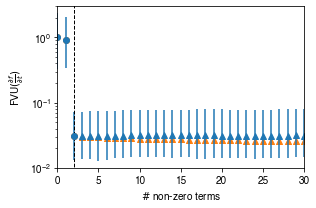

In [23]:
def accuracy_complexity_plot(regression_results):
    n_nonzero_terms, model_form_var = variance_of_model_form_with_mterms(regression_results)

    plt.figure(figsize=(4.5,3))
    _ = rebin_errors_vs_numnonzeroterms(regression_results, 'mse_train', if_display_modelformvariance = True)
    _ = rebin_errors_vs_numnonzeroterms(regression_results, 'mse_test', if_display_modelformvariance = True)

    plt.vlines(2, 1e-5, 10, ls='--', lw = 1)

    plt.ylim(1e-2,3e0)
    plt.xlim(0,30)
    plt.xlabel(r'$\#$ non-zero terms')
    plt.ylabel(r'$\mathrm{FVU}(\frac{\partial f}{\partial t})$')
    plt.tight_layout()
    
    
accuracy_complexity_plot(reg_results)

## Plot the discovered model with M terms
We next examine the variance in our discovered models from K-folds cross validation. For M=2, each time SR is performed the same two term model - involving vF_x and EF_u - is inferred. For M=3, SR inferrs many different three term models all involving vF_x and EF_u, yet with many other possibilities for the final term. The variance of '3 term model forms' gives credence that the inferred model contains 2 rather than 3 terms.

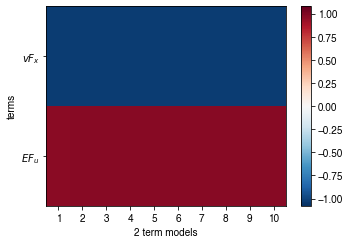

In [24]:
discovered_Mterm_models(reg_results, description, M = 2)

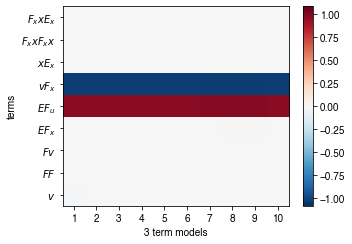

In [25]:
discovered_Mterm_models(reg_results, description, M = 3)

## Examine the values of the inferred coefficients

In [26]:
model_terms = ['vF_x', 'EF_u']
sparsity_pattern = np.zeros(len(description))
for term in model_terms:
    sparsity_pattern += (np.array(description) == term)

sparsity_pattern = sparsity_pattern.astype(bool)

final_Xi = LS_estimation_for_given_sparsity_pattern(Theta, Y, description, sparsity_pattern)



Nonzero terms: ['EF_u' 'vF_x']
Mean Coefficient values (on full data): [ 0.98000709 -1.02245203]


## The full equation is thus F_t = 0.98000709 EF_u -1.02245203 vF_x

For more detailed information see https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.033192